# Preliminary results for label detection & classification

1. Can we find labels on images of herbarium specimens.
1. Can we determine if the label is typewritten, handwritten, or both.

## Ancilllary goals

1. Use a preexisting model. In this case, Faster-RCNN with a ResNet50 backbone. We're not doing anything that requires a new model.
1. Fine-tune an already trained model. The model was trained on the COCO dataset. We're only looking for labels on the images, so any model pre-trained on the COCO dataset should be more than enough for this task.

In [1]:
from pathlib import Path
from textwrap import dedent
import pdb

from tqdm import tqdm
from ipywidgets import interact
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import transforms as T
from engine import train_one_epoch, evaluate
import utils

The Python environment.

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

%load_ext watermark
%watermark -i -z -v -p torch,torchvision

EDT2019-06-24T10:28:08-04:00

CPython 3.7.3
IPython 7.5.0

torch 1.1.0
torchvision 0.3.0


In [3]:
DATA_DIR = Path('.') / 'data'
VAL_DIR = DATA_DIR / 'valid'
MODEL_DIR = DATA_DIR / 'models'

VAL_CSV = DATA_DIR / 'valid.csv'

BOX = 'box'
CAT = 'category'
PATH = 'path'
CLASS = 'class'
SUB_ID = 'subject_id'

DEVICE = torch.device('cuda')
torch.backends.cudnn.benchmark = True # Optimizes cudnn

CATS = ['background', 'handwritten', 'typewritten']
CLASSES = len(CATS)

STATE = MODEL_DIR / 'checkpoint_02.pth.tar'

# Load the trained model

Read in the hold-out (or validation) dataset. The model was *not* trained on this data.

**However the data did come from the same expedition as the training data & it may, therefore, contain a hidden bias.**

What we really want to do is test the *final* model on datasets from other herbaria.

In [4]:
val_df = pd.read_csv(VAL_CSV, index_col='subject_id').reset_index()

val_df.head()

subject_id     category  class                   box  \
0     2995202  typewritten      2  [228, 459, 367, 568]   
1     2995203  typewritten      2  [238, 462, 377, 572]   
2     2995205  typewritten      2  [252, 486, 373, 564]   
3     2995213  typewritten      2  [224, 474, 373, 566]   
4     2995216  handwritten      1  [239, 462, 367, 562]   

                     path                 original  
0  data/valid/2995202.jpg  data/images/2995202.jpg  
1  data/valid/2995203.jpg  data/images/2995203.jpg  
2  data/valid/2995205.jpg  data/images/2995205.jpg  
3  data/valid/2995213.jpg  data/images/2995213.jpg  
4  data/valid/2995216.jpg  data/images/2995216.jpg

In [5]:
class LabelBabelDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms):
        df[BOX] = df[BOX].apply(json.loads)
        self.df = df
        self.transforms = transforms

    def __getitem__(self, idx):
        subject = self.df.iloc[idx]

        image = Image.open(subject[PATH]).convert('RGB')

        klass = int(subject[CLASS])
        labels = torch.full((1,), klass, dtype=torch.int64)

        boxes = [subject[BOX]]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([subject[SUB_ID]])

        if self.transforms is not None:
            image, target = self.transforms(image, target)
        
        return image, target

    def __len__(self):
        return self.df.shape[0]

# The model

- Faster R-CNN with a ResNet50 backbone.
- The model was previously trained on the COCO dataset.
- The training dataset has 4865 labeled images.
- The validation dataset has 1216 labeled images.
- I trained the model for *only* 5 epochs
- There was almost no data augmentation.

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, CLASSES)

In [7]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [8]:
val_dataset = LabelBabelDataset(val_df, get_transform(train=False))

In [9]:
model.to(DEVICE)
model.eval();

# Load the fine-tuned model weights

In [10]:
state = torch.load(STATE)
model.load_state_dict(state['state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [11]:
def intersetion_over_area(box1, box2):
    area1 = abs(box1[2] - box1[0]) * abs(box1[3] - box1[1])
    area2 = abs(box2[2] - box2[0]) * abs(box2[3] - box2[1])
    inter = (min(box1[2], box2[2]) - max(box1[0], box2[0])) \
        * (min(box1[3], box2[3]) - max(box1[1], box2[1]))
    inter = max(0, inter)
    return abs(inter / (area1 + area2 - inter))

In [12]:
def draw_rectangle(ax, bbox, color):
    wide = abs(bbox[2] - bbox[0])
    high = abs(bbox[3] - bbox[1])
    rect = patches.Rectangle(
        bbox[:2],
        wide, high,
        fill=False,
        edgecolor=color,
        lw=2)
    patch = ax.add_patch(rect)

In [13]:
def draw_text(ax, position, text, fontsize=10):
    ax.text(
        *position,
        text,
        verticalalignment='top',
        color='black',
        fontsize=fontsize,
        fontfamily='monospace',
        weight='bold',
        bbox=dict(
            boxstyle='round',
            facecolor='white',
            edgecolor='black'))

# Explore results

Key:
- Blue box is the target gotten from the reconciled data.
- Red box is what the model says is the best prediction.
- Yellow boxes (0 or more) are other predictions by the model.

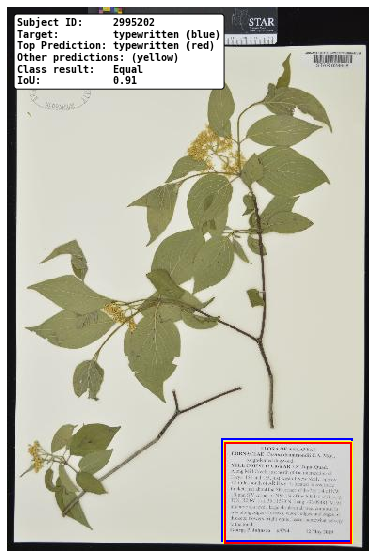

In [14]:
def show_results(idx, figsize):
    image, target = val_dataset[idx]

    subject_id = target['image_id'][0].numpy()

    t_class = CATS[target['labels'][0].numpy()]
    t_box = target['boxes'][0].numpy()

    fig, ax = plt.subplots(figsize=(figsize, figsize))
    ax.axis('off')

    with torch.no_grad():
        prediction = model([image.to(DEVICE)])

    p_class = CATS[prediction[0]['labels'].cpu()[0].numpy()]
    p_box = prediction[0]['boxes'].cpu()[0].numpy()

    iou = round(intersetion_over_area(t_box, p_box), 2)
    class_flag = 'Equal' if t_class == p_class else 'NOT EQUAL'
    box_flag = '' if iou >= 0.8 else 'AREA MISMATCH'

    text = dedent(f"""\
            Subject ID:     {subject_id}
            Target:         {t_class} (blue)
            Top Prediction: {p_class} (red)
            Other predictions: (yellow)
            Class result:   {class_flag}
            IoU:            {iou:0.2} {box_flag}""")

    image = Image.fromarray(image.mul(255).permute(1, 2, 0).byte().numpy())

    ax.imshow(image)
    draw_text(ax, (10, 10), text)

    draw_rectangle(ax, t_box, 'blue')

    # Show the boxes in reverse order so the seleted one is uncovered
    boxes = prediction[0]['boxes'].cpu().numpy()
    for i, box in enumerate(boxes[::-1], 1):
        color = 'red' if i == len(boxes) else 'yellow'
        draw_rectangle(ax, box, color)

    plt.show()


# interact(
#     show_results,
#     idx=(0, val_df.shape[0] - 1),
#     figsize=([6, 8, 10, 12, 15, 20, 25]))
show_results(0, 10)

# Sideways: 518-541  748-754
# Interesting: 763,1122
# Better: 1182,1213

## Show multiple results in a single image

I use this function to explore how different parameters contributed to the success or failure of the model.

In [15]:
def show_multiple_results(indices, height, width=None):
    ncols = len(indices)

    if not width:
        width = height * ncols * 0.667

    fig, axes = plt.subplots(
        nrows=1,
        ncols=ncols,
        figsize=(width, height),
        constrained_layout=True)

    for i, idx in enumerate(indices):
        image, target = val_dataset[idx]

        subject_id = target['image_id'][0].numpy()

        t_class = CATS[target['labels'][0].numpy()]
        t_box = target['boxes'][0].numpy()

        with torch.no_grad():
            prediction = model([image.to(DEVICE)])

        p_class = CATS[prediction[0]['labels'].cpu()[0].numpy()]
        p_box = prediction[0]['boxes'].cpu()[0].numpy()

        iou = round(intersetion_over_area(t_box, p_box), 2)
        class_flag = 'Equal' if t_class == p_class else 'NOT EQUAL'
        box_flag = '' if iou >= 0.8 else 'AREA MISMATCH'

        text = dedent(f"""\
                Subject ID:     {subject_id}
                Target:         {t_class} (blue)
                Top Prediction: {p_class} (red)
                Other predictions: (yellow)
                Class result:   {class_flag}
                IoU:            {iou:0.2} {box_flag}""")

        image = Image.fromarray(image.mul(255).permute(1, 2, 0).byte().numpy())

        axes[i].imshow(image)
        draw_text(axes[i], (10, 10), text)

        draw_rectangle(axes[i], t_box, 'blue')

        # Show the boxes in reverse order so the seleted one is uncovered
        boxes = prediction[0]['boxes'].cpu().numpy()
        for j, box in enumerate(boxes[::-1], 1):
            color = 'red' if j == len(boxes) else 'yellow'
            draw_rectangle(axes[i], box, color)

    for ax in axes.flat:
        ax.axis('off')

    plt.show()

# Object detection results IoU >= 90%

Intersection over union >= 90%: 1097 (90.21% of the images)

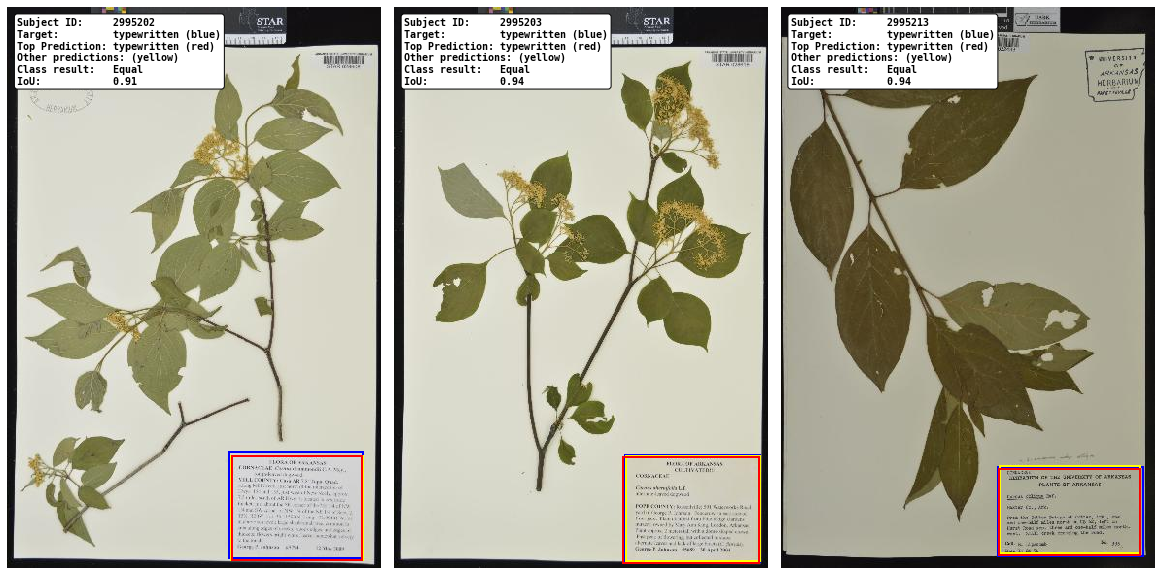

In [16]:
show_multiple_results([0, 1, 3], 8)

# Object detection results IoU >= 90% (image orientation)

I didn't expect this model to handle different orientations without more data augmentation but it did.

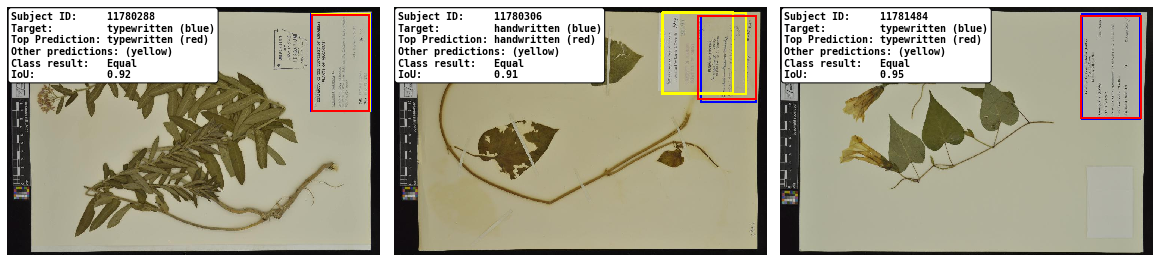

In [17]:
show_multiple_results([518, 520, 748], 4, 16)

# Object detection results IoU >= 80% and < 90%

Intersection over union 80-90%: 103 (8.47%)

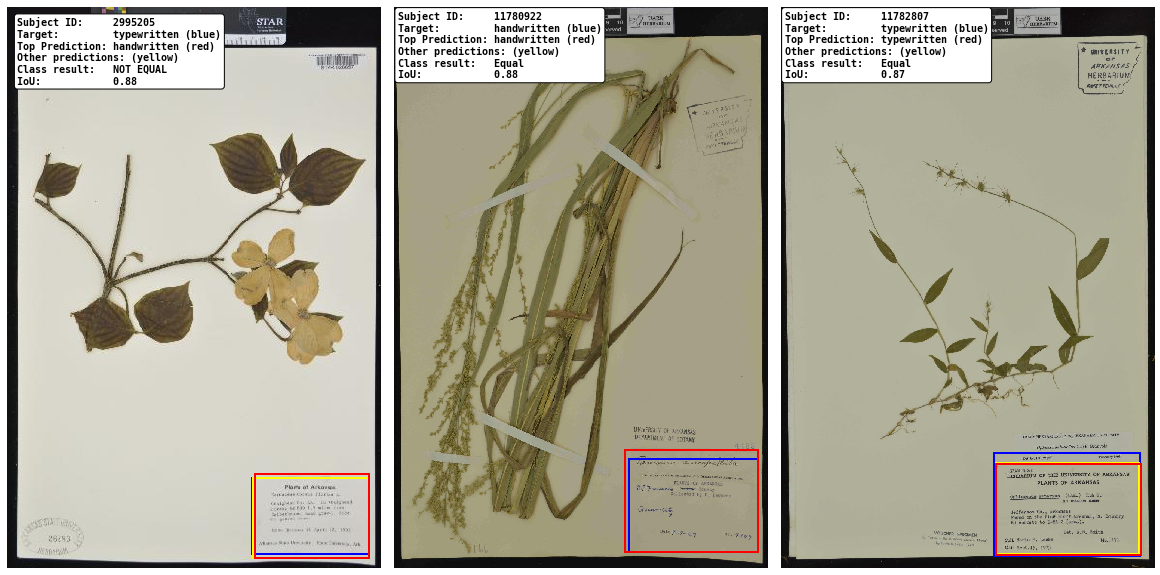

In [18]:
show_multiple_results([2, 637, 1029], 8)

# Object detection results IoU < 80%

Some of the times the model appears to do better than the volunteers, and other times not so much.

Intersection over union < 80%: 13 (1.07%)

| Index | Subject ID |
| ----- | ---------- |
| 7 | 2995235 |
| 67 | 2995585 |
| 136 | 4128416 |
| 145 | 4128467 |
| 171 | 4128609 |
| 306 | 10667753 |
| 410 | 10668286 |
| 509 | 11780234 |
| 1032 | 11782819 |
| 1077 | 11783073 |
| 1177 | 11783591 |
| 1182 | 11783605 |
| 1213 | 11783734 |

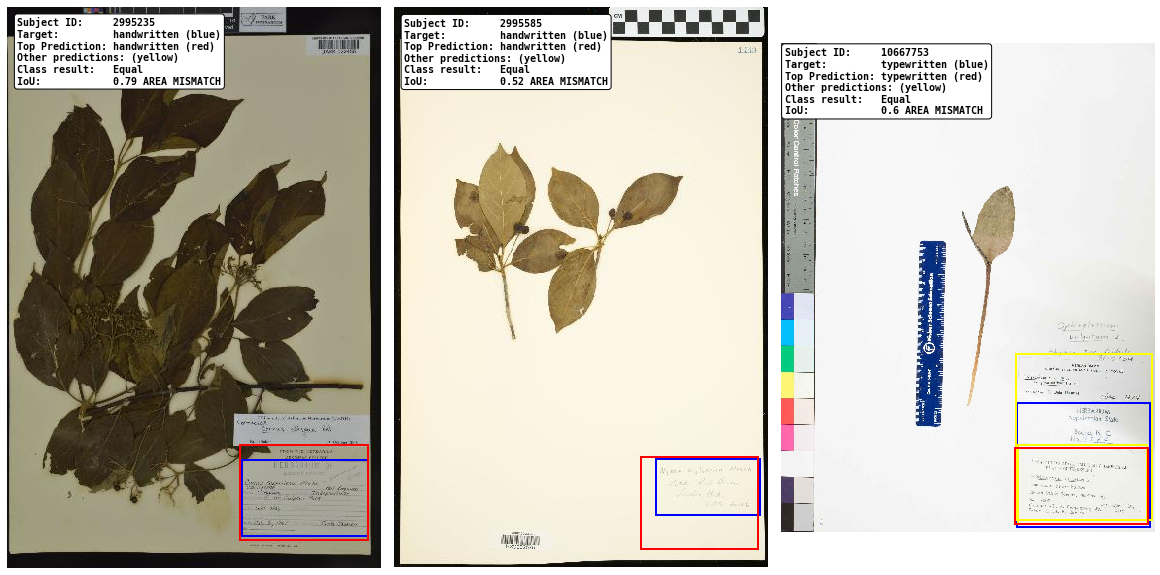

In [19]:
show_multiple_results([7, 67, 306], 8)

# Object detection results IoU = 0%

Notice that in each of these cases a ancillary choice does have a significant overlap with the target.

Intersection over union = 0%: 3 (0.25%)

| Index | Subject ID |
| ----- | ---------- |
| 496 | 11780193 |
| 763 | 11781551 |
| 1122 | 11783308 |

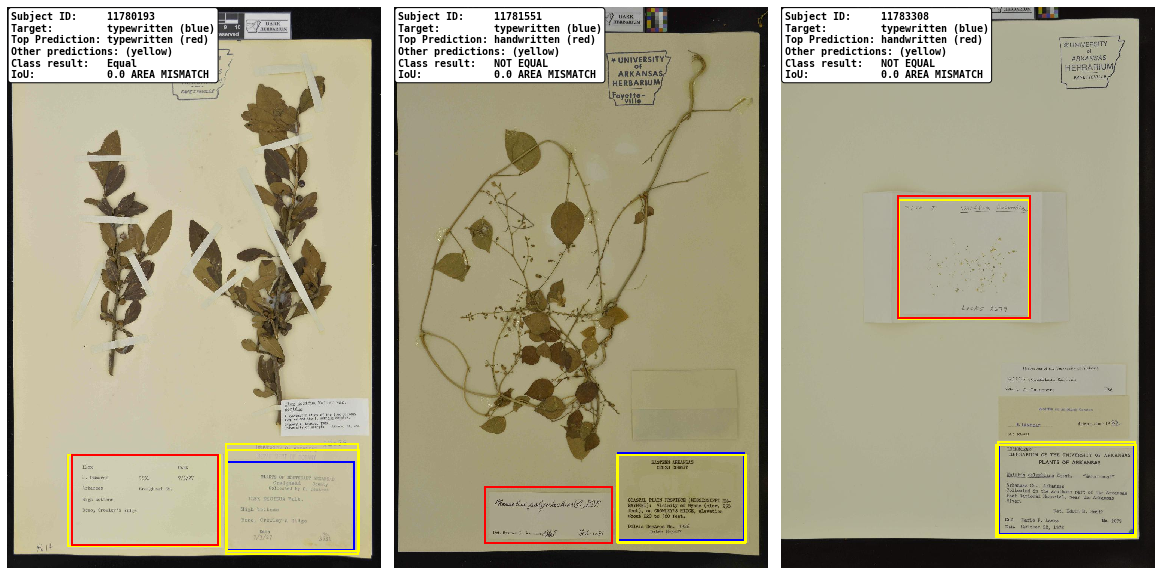

In [26]:
show_multiple_results([496, 763, 1122], 8)

# Classification results

- There are 1216 items in the validation set.
- There were 1133 (93.17%) correctly identified classes.
- Handwritten -> Typewritten errors (4.93%).
- Typewritten -> Handwritten errors (1.89%).

# Handwritten -> Typewritten errors

Handwritten -> Typewritten errors (4.93%).

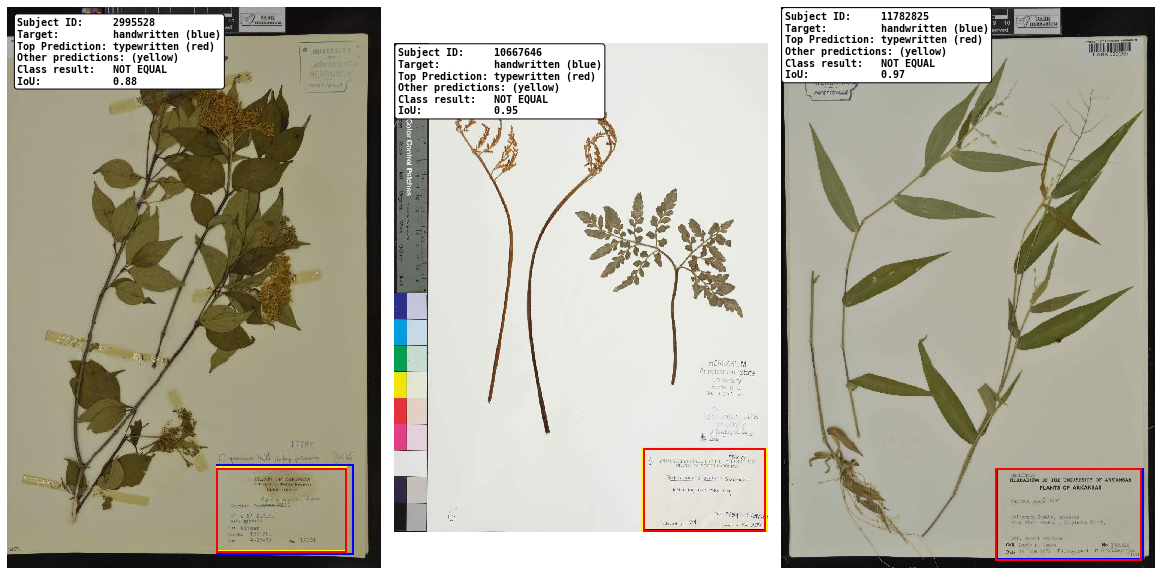

In [27]:
show_multiple_results([54, 281, 1033], 8)

# Typewritten -> Handwritten errors

Typewritten -> Handwritten errors (1.89%)

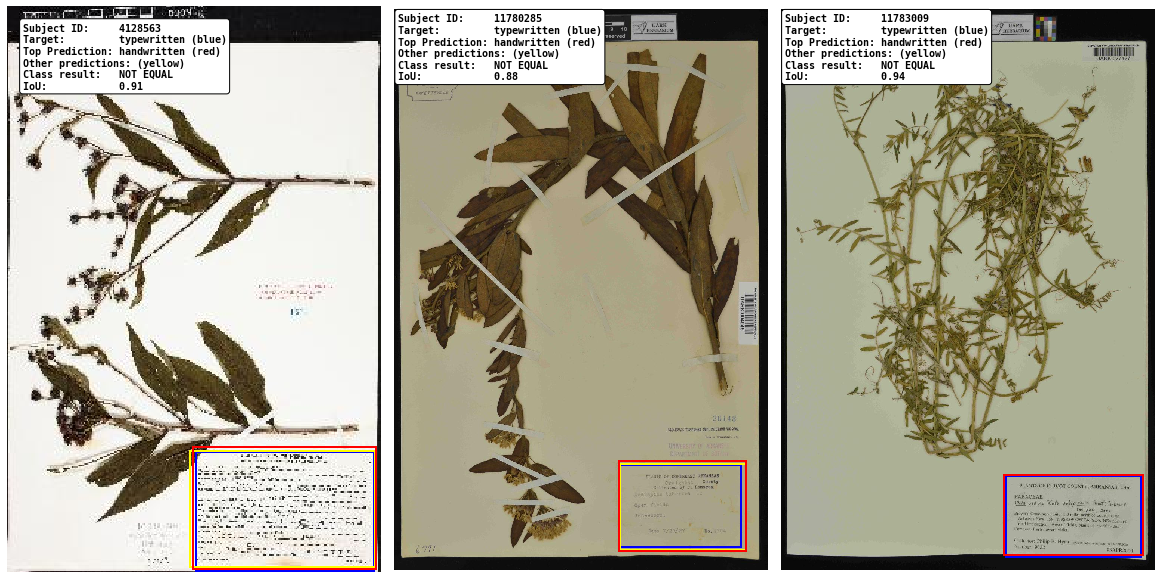

In [28]:
show_multiple_results([164, 517, 1064], 8)

# Numeric results

In [25]:
def bin_results():
    results = {
        'eq': 0,
        '1->2': [],
        '2->1': [],
        '>=90': 0,
        '<90': 0,
        '<80': [],
        '=0': [],
        'n': len(val_dataset),
    }

    for i, (image, target) in tqdm(enumerate(val_dataset)):

        image_id = target["image_id"][0].numpy().item()

        t_class = target['labels'][0].numpy()
        t_box = target['boxes'][0].numpy()

        with torch.no_grad():
            prediction = model([image.to(DEVICE)])

        p_class = prediction[0]['labels'].cpu()[0].numpy()
        p_box = prediction[0]['boxes'].cpu()[0].numpy()

        if t_class == p_class:
            results['eq'] += 1
        elif t_class == 1:
            results['1->2'].append((i, image_id))
        else:
            results['2->1'].append((i, image_id))

        iou = round(intersetion_over_area(t_box, p_box), 2)

        if iou == 0:
            results['=0'].append((i, image_id))
        elif iou < 0.8:
            results['<80'].append((i, image_id))
        elif iou < 0.9:
            results['<90'] += 1
        else:
            results['>=90'] += 1

    return results


def print_results(results):
    n = results["n"]
    print(f'There are {n} items in the validation set.')
    print()

    per = round(results["eq"] / results["n"] * 100.0, 2)
    print(f'There were {results["eq"]} ({per}%) correctly identified classes')
    print()

    per = round(len(results["1->2"]) / results["n"] * 100.0, 2)
    print(f'Handwritten -> Typewritten errors ({per}%):')
    print('| Index | Subject ID |')
    print('| ----- | ---------- |')
    for x in results["1->2"]:
        print(f'| {x[0]} | {x[1]} |')
    print()

    per = round(len(results["2->1"]) / results["n"] * 100.0, 2)
    print(f'Typewritten -> Handwritten errors ({per}%):')
    print('| Index | Subject ID |')
    print('| ----- | ---------- |')
    for x in results["2->1"]:
        print(f'| {x[0]} | {x[1]} |')
    print()

    per = round(results[">=90"] / results["n"] * 100.0, 2)
    print(f'Intersection over union >= 90%: {results[">=90"]} ({per}%)')
    print()

    per = round(results["<90"] / results["n"] * 100.0, 2)
    print(f'Intersection over union 80-90%: {results["<90"]} ({per}%)')
    print()

    per = round(len(results["<80"]) / results["n"] * 100.0, 2)
    print(f'Intersection over union < 80%: {len(results["<80"])} ({per}%)')
    print('| Index | Subject ID |')
    print('| ----- | ---------- |')
    for x in results["<80"]:
        print(f'| {x[0]} | {x[1]} |')
    print()

    per = round(len(results["=0"]) / results["n"] * 100.0, 2)
    print(f'Intersection over union = 0%: {len(results["=0"])} ({per}%)')
    print('| Index | Subject ID |')
    print('| ----- | ---------- |')
    for x in results["=0"]:
        print(f'| {x[0]} | {x[1]} |')


results = bin_results()
print_results(results)

1216it [02:00,  9.63it/s]

There are 1216 items in the validation set.

There were 1133 (93.17%) correctly identified classes

Handwritten -> Typewritten errors (4.93%):
| Index | Subject ID |
| ----- | ---------- |
| 6 | 2995232 |
| 54 | 2995528 |
| 64 | 2995577 |
| 103 | 4128276 |
| 110 | 4128309 |
| 117 | 4128343 |
| 149 | 4128476 |
| 150 | 4128490 |
| 152 | 4128495 |
| 153 | 4128501 |
| 168 | 4128577 |
| 170 | 4128594 |
| 189 | 4128718 |
| 218 | 4128891 |
| 279 | 10667640 |
| 281 | 10667646 |
| 382 | 10668130 |
| 422 | 11779826 |
| 443 | 11779934 |
| 447 | 11779943 |
| 449 | 11779945 |
| 453 | 11779971 |
| 458 | 11779986 |
| 469 | 11780060 |
| 477 | 11780091 |
| 522 | 11780315 |
| 540 | 11780399 |
| 580 | 11780657 |
| 613 | 11780818 |
| 643 | 11780960 |
| 691 | 11781208 |
| 701 | 11781263 |
| 757 | 11781525 |
| 777 | 11781624 |
| 789 | 11781683 |
| 815 | 11781762 |
| 817 | 11781766 |
| 824 | 11781792 |
| 877 | 11782044 |
| 891 | 11782100 |
| 894 | 11782122 |
| 905 | 11782164 |
| 925 | 11782306 |
| 927 | 1178

# To do

- Build a pipeline to extract the images
- Train the model for longer, possibly 2 orders of magnitude more epochs.
- Try smaller and quicker models
- Augment the data: color jitter, image rotations, image flips, etc.
- Try smaller and faster models.